# Welding Example #02: TCP movements and Weaving
In this example we will focus on more complex tcp movements along the workpiece and how to combine different motion shapes like weaving.

## Imports

In [1]:
# if the package is not installed in your python environment, run this to execute the notebook directly from inside the GitHub repository
%cd -q ..

In [2]:
# enable interactive plots on Jupyterlab with ipympl and jupyterlab-matplotlib installed
# %matplotlib widget

In [3]:
# some python imports that will be used throughout the tutorial
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pint
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# importing the weldx package with prevalent default abbreviations
import weldx
import weldx.geometry as geo
import weldx.transformations as tf
import weldx.utility as ut
import weldx.visualization as vis
from weldx import Q_
from weldx.core import MathematicalExpression, TimeSeries
from weldx.transformations import LocalCoordinateSystem as lcs
from weldx.transformations import WXRotation

## General setup
We will use the same workpiece geometry as defined in the previous example.

### groove shape

In [5]:
from weldx.asdf.tags.weldx.core.iso_groove import get_groove

groove = get_groove(
    groove_type="VGroove",
    workpiece_thickness=Q_(0.5, "cm"),
    groove_angle=Q_(50, "deg"),
    root_face=Q_(1, "mm"),
    root_gap=Q_(1, "mm"),
)

### workpiece geometry

In [6]:
# define the weld seam length in mm
seam_length = 150

# create a linear trace segment a the complete weld seam trace
trace_segment = geo.LinearHorizontalTraceSegment(seam_length)
trace = geo.Trace(trace_segment)

# create 3d workpiece geometry from the groove profile and trace objects
geometry = geo.Geometry(groove.to_profile(width_default=Q_(4, "mm")), trace)

# rasterize geometry
profile_raster_width = 0.5  # resolution of each profile in mm
trace_raster_width = 15  # space between profiles in mm
geometry_data_sp = geometry.rasterize(
    profile_raster_width=profile_raster_width, trace_raster_width=trace_raster_width
)

### Coordinate system manager

In [7]:
# crete a new coordinate system manager with default base coordinate system
csm = weldx.transformations.CoordinateSystemManager("base")

# add the workpiece coordinate system
csm.add_cs(coordinate_system_name="workpiece", reference_system_name="base", lcs=trace.coordinate_system)

## Movement definitions
Like in the previous example we start by defining the general linear movement along the weld seam with a constant welding speed.

In [8]:
tcp_start_point = Q_([5.0, 0.0, 2.0], "mm")
tcp_end_point = Q_([seam_length - 5.0, 0.0, 2.0], "mm")

v_weld = Q_(10, "mm/s")
s_weld = (tcp_end_point - tcp_start_point)[0]  # length of the weld
t_weld = s_weld / v_weld

t_start = pd.Timedelta("0s")
t_end = pd.Timedelta(str(t_weld))

rot = WXRotation.from_euler("x", 180, degrees=True)

coords = [tcp_start_point.magnitude, tcp_end_point.magnitude]

tcp_wire = lcs(
    coordinates=coords, orientation=rot, time=[t_start, t_end]
)

Let's add the linear movement to the coordinate system manager and see a simple plot:

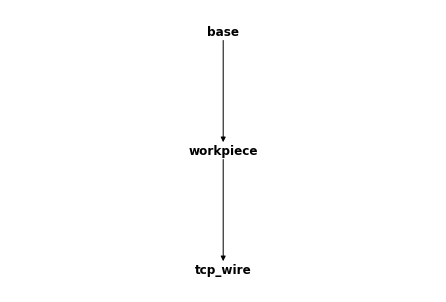

In [9]:
csm.add_cs(coordinate_system_name="tcp_wire", reference_system_name="workpiece", lcs=tcp_wire)
csm

In [10]:
def ax_setup(ax):
    ax.legend()
    ax.set_xlabel("x / mm")
    ax.set_ylabel("y / mm")
    ax.set_zlabel("z / mm")

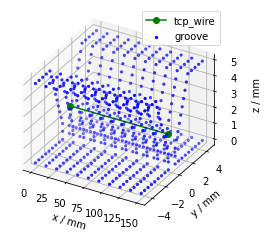

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d", proj_type="ortho")
ax.scatter(
    geometry_data_sp[0, :],
    geometry_data_sp[1, :],
    geometry_data_sp[2, :],
    marker=".",
    c="b",
    label="groove",
)

cs = cs = csm.get_cs("tcp_wire", "workpiece")
data = cs.coordinates.data
ax.plot(data[:, 0], data[:, 1], data[:, 2], label="tcp_wire", c="g", marker="o")

ax_setup(ax)

## add a sine wave to the TCP movement
We now want to add a weaving motion along the y-axis (horizontal plane) of our TCP motion. We can define a general weaving motion using the `TimeSeries` class.

In [12]:
def sine_exp(amp, freq):
    """Create a simple sine TimeSeries."""
    expr_string = "amp*sin(f*t)"
    parameters = {"amp": amp, "f": freq}
    expr = MathematicalExpression(expression=expr_string, parameters=parameters)
    return TimeSeries(data=expr)

In [13]:
ts_sine = sine_exp(Q_([[0, 0.75, 0]], "mm"), Q_(1.5 * 2 * np.pi, "Hz"))

ts_sine_data = ts_sine.interp_time(
    pd.timedelta_range(start=t_start, end=t_end, freq="10ms")
)

# assign vector coordinates and convert to m
ts_sine_data = ts_sine_data.rename({"dim_1": "c"}).assign_coords({"c": ["x", "y", "z"]})
ts_sine_data.data = ts_sine_data.data.magnitude
ts_sine_data["time"] = pd.TimedeltaIndex(ts_sine_data["time"].data)

We now define a simple coordinate system that contains only the weaving motion.

In [14]:
tcp_sine = lcs(coordinates=ts_sine_data)

One approach to combine the weaving motion with the existing linear _tcp_wire_ movement is to use the coordinate system manager. We can add the _tcp_sine_ coordinate system relative to the _tcp_wire_ system:

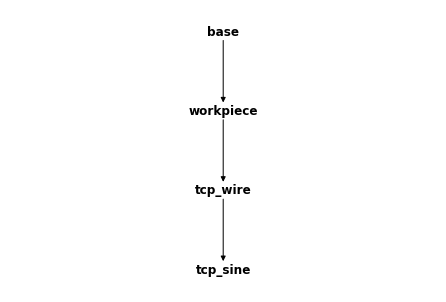

In [15]:
csm.add_cs(coordinate_system_name="tcp_sine", reference_system_name="tcp_wire", lcs=tcp_sine)
csm

Lets see the result:

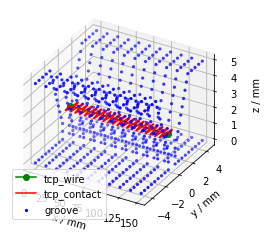

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d", proj_type="ortho")
ax.scatter(
    geometry_data_sp[0, :],
    geometry_data_sp[1, :],
    geometry_data_sp[2, :],
    marker=".",
    c="b",
    label="groove",
)

cs = csm.get_cs("tcp_wire", "workpiece")
data = cs.coordinates.data
ax.plot(data[:, 0], data[:, 1], data[:, 2], label="tcp_wire", c="g", marker="o")

cs = csm.get_cs("tcp_sine", "workpiece")
data = cs.coordinates.data
ax.plot(data[:, 0], data[:, 1], data[:, 2], label="tcp_contact", c="r")

ax_setup(ax)

Another approach would be to combine both systems before adding them to the coordinate system manager. We can combine both coordinate systems using the __+__ operator to generate the superimposed weaving coordinate system.

In [17]:
tcp_wire_sine = tcp_sine + tcp_wire

Note the difference in reference coordinate system compared to the first example.

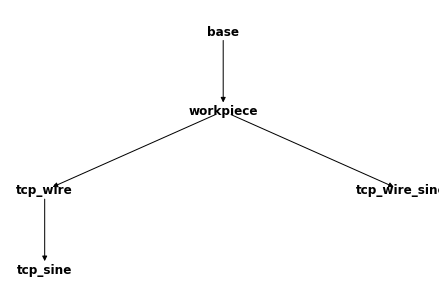

In [18]:
csm.add_cs("tcp_wire_sine", "workpiece", tcp_wire_sine)
csm

We get the same result:

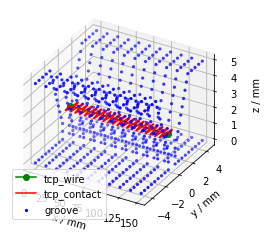

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d", proj_type="ortho")
ax.scatter(
    geometry_data_sp[0, :],
    geometry_data_sp[1, :],
    geometry_data_sp[2, :],
    marker=".",
    c="b",
    label="groove",
)

cs = csm.get_cs("tcp_wire", "workpiece")
data = cs.coordinates.data
ax.plot(data[:, 0], data[:, 1], data[:, 2], label="tcp_wire", c="g", marker="o")

cs = csm.get_cs("tcp_wire_sine", "workpiece")
data = cs.coordinates.data
ax.plot(data[:, 0], data[:, 1], data[:, 2], label="tcp_contact", c="r")

ax_setup(ax)

Adding every single superposition step in the coordinate system manager can be more flexible and explicit, but will clutter the CSM instance for complex movements.

## plot with time interpolation
Sometimes we might only be interested in a specific time range of the experiment or we want to change the time resolution. For this we can use the time interpolation methods of the coordinate systems (or the CSM).

Let's say we want to weave only 8 seconds of our experiment (starting from 2020-04-20 10:03:00) but interpolate steps of 1 ms.

In [20]:
t_interp = pd.timedelta_range(start="0s", end="11s", freq="1ms")

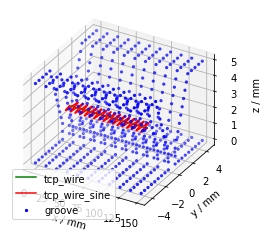

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d", proj_type="ortho")
ax.scatter(
    geometry_data_sp[0, :],
    geometry_data_sp[1, :],
    geometry_data_sp[2, :],
    marker=".",
    c="b",
    label="groove",
)

cs = csm.get_cs("tcp_wire", "workpiece").interp_time(t_interp)
data = cs.coordinates.data
ax.plot(data[:, 0], data[:, 1], data[:, 2], label="tcp_wire", c="g")

cs = csm.get_cs("tcp_wire_sine", "workpiece").interp_time(t_interp)
data = cs.coordinates.data
ax.plot(data[:, 0], data[:, 1], data[:, 2], label="tcp_wire_sine", c="r")

ax_setup(ax)

## Adding a second weaving motion
We now want to add a second weaving motion along the z-axis that only exists for a limited time. Lets generate the motion first:

In [22]:
ts_sine = sine_exp(Q_([[0, 0, 1]], "mm"), Q_(1 / 8 * 2 * np.pi, "Hz"))

ts_sine_data = ts_sine.interp_time(
    pd.timedelta_range(start="0s", end="8s", freq="25ms")
)

# assign vector coordinates and convert to m
ts_sine_data = ts_sine_data.rename({"dim_1": "c"}).assign_coords({"c": ["x", "y", "z"]})
ts_sine_data.data = ts_sine_data.data.magnitude
ts_sine_data["time"] = pd.TimedeltaIndex(ts_sine_data["time"].data)

tcp_sine2 = lcs(coordinates=ts_sine_data)

In [23]:
tcp_sine2

<LocalCoordinateSystem>
Dimensions:      (c: 3, time: 321, v: 3)
Coordinates:
  * time         (time) timedelta64[ns] 00:00:00 00:00:00.025000 ... 00:00:08
  * c            (c) <U1 'x' 'y' 'z'
  * v            (v) int32 0 1 2
Data variables:
    coordinates  (time, c) float64 0.0 0.0 0.0 0.0 ... -0.0 -0.0 -2.449e-16
    orientation  (v, c) float64 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0

adding all the movements together. We have to be careful with the time-axis in this case !

In [24]:
t_interp = pd.timedelta_range(start=tcp_wire.time[0].values, end=tcp_wire.time[-1].values, freq="20ms")

In [25]:
tcp_wire_sine2 = (
    tcp_sine2.interp_time(t_interp) + tcp_sine.interp_time(t_interp)
) + tcp_wire

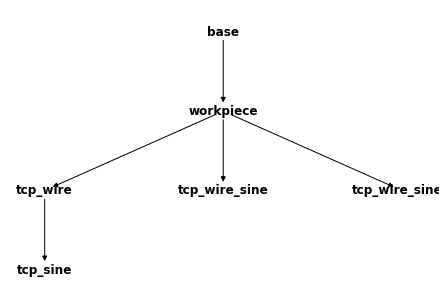

In [26]:
csm.add_cs("tcp_wire_sine2", "workpiece", tcp_wire_sine2)
csm

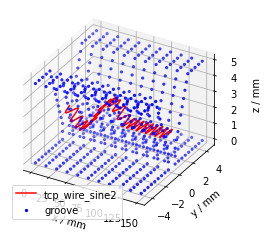

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d", proj_type="ortho")
ax.scatter(
    geometry_data_sp[0, :],
    geometry_data_sp[1, :],
    geometry_data_sp[2, :],
    marker=".",
    c="b",
    label="groove",
)

cs = csm.get_cs("tcp_wire_sine2", "workpiece")
# cs = tcp_wire_sine2
data = cs.coordinates.data
ax.plot(data[:, 0], data[:, 1], data[:, 2], label="tcp_wire_sine2", c="r")

ax_setup(ax)